In [33]:
import anndata
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
import statsmodels.api as sm
from scipy.stats import spearmanr
from scipy.stats import pearsonr
import scanpy as sc
from matplotlib_venn import venn2
import scrublet as scr
import pandas as pd
from pybiomart import Server
import upsetplot as ups
import itertools
from upsetty import Upset

In [2]:
%matplotlib inline

In [3]:
# read in processed data for each method
data_10x = anndata.read_h5ad('processed_10x.h5ad')
data_polyT = anndata.read_h5ad('processed_polyT.h5ad')
data_randO = anndata.read_h5ad('processed_randO.h5ad')
data_parse = anndata.read_h5ad('processed_parse.h5ad')

In [4]:
datasets = [data_10x, data_polyT, data_randO, data_parse]

In [49]:
# Filter data to ensure no zero counts/genes/cells
for data, name, title in zip(datasets,
                            ['10x', 'polyT', 'randO', 'parse'],
                            ["10x Genomics", "Parse 3\'", "Parse Random Oligo", "Parse"]):
    data.uns['name'] = name
    data.uns['title'] = title
    sc.pp.filter_cells(data, min_genes=1)
    sc.pp.filter_genes(data, min_cells=1)
    sc.pp.filter_cells(data, min_counts=1)

# Downsample

In [6]:
# Downsample the data to however many counts the smallest dataset has
total_counts = min([data_10x.X.sum(), data_polyT.X.sum(), data_randO.X.sum(), data_parse.X.sum()])
for data in [data_10x, data_polyT, data_randO, data_parse]:
    sc.pp.downsample_counts(data, total_counts=total_counts, replace=False, random_state=42)
    sc.pp.filter_cells(data, min_genes=1)
    sc.pp.filter_genes(data, min_cells=1)
    sc.pp.filter_cells(data, min_counts=1)

In [7]:
print("Total counts after downsampling:", total_counts)

Total counts after downsampling: 20286665.0


# Population Upsampling Estimation

In [ ]:
# Find the projected number of unique transcripts to be found using each method if sampling were to continue
# Using PreSeq (Daley and Smith 2013) based off of the recommendation from this paper: https://www.biorxiv.org/content/10.1101/2024.10.09.615408v1.full.pdf

for data in datasets:
    filename = f"counts/{data.uns['name']}_counts.txt"
    fileout = f"counts/{data.uns['name']}_yield.txt"
    with open(filename, "w") as f:
        counts = data.X.sum(axis=0).A1
        for count in counts:
            f.write(f"{int(count)}\n")
    !preseq lc_extrap -o {fileout} -V {filename}
    with open(fileout, "r") as f:
        rows = []
        first_line = f.readline()
        for line in f:
            rows.append(list(map(float,line.split())))
    data.uns['pred_upsample'] = np.array(rows)

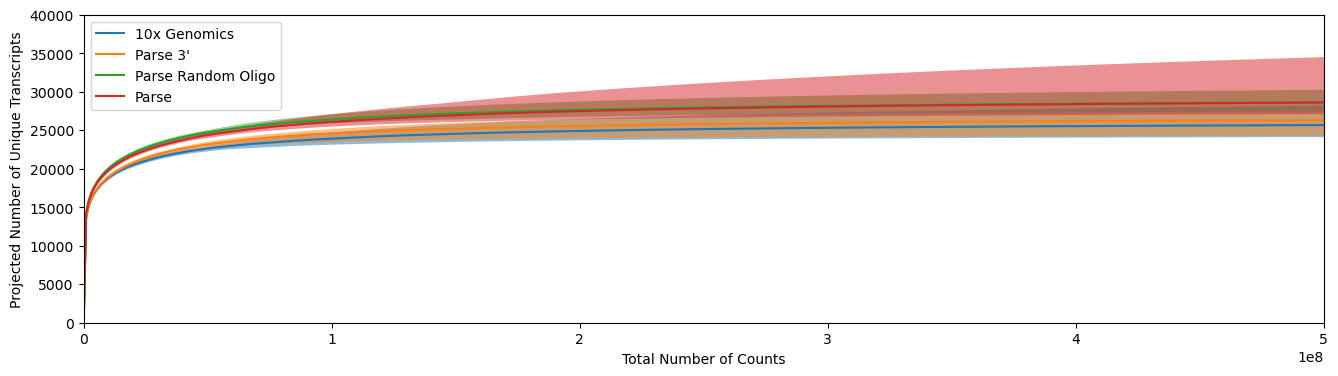

In [ ]:
plt.figure(figsize=(16, 4))
for data in datasets:
    pred = data.uns['pred_upsample']
    plt.plot(pred[:, 0], pred[:, 1], label=data.uns['title'])
    plt.fill_between(pred[:, 0], pred[:,2], pred[:,3], alpha=0.5)

plt.legend(loc='upper left')
plt.xlim(0,5e8)
plt.ylim(0, 4e4)
plt.xlabel('Total Number of Counts')
plt.ylabel('Projected Number of Unique Transcripts')
plt.show()

# Doublet Detection Comparison

In [8]:
scrubs = []
for data in datasets:
    scrub = scr.Scrublet(data.X, random_state = 42)
    data.obs['doublet_score'], data.obs['predicted_doublet'] = scrub.scrub_doublets()
    scrubs.append(scrub)

Preprocessing...


/home/mcaskey/miniconda3/envs/10XvParse/lib/python3.12/site-packages/scrublet/helper_functions.py:254: RuntimeWarning: invalid value encountered in sqrt
  CV_input = np.sqrt(b);


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.42
Detected doublet rate = 0.3%
Estimated detectable doublet fraction = 3.5%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 9.0%
Elapsed time: 2807.1 seconds
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.07
Detected doublet rate = 46.7%
Estimated detectable doublet fraction = 68.3%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 68.3%
Elapsed time: 705.3 seconds
Preprocessing...


/home/mcaskey/miniconda3/envs/10XvParse/lib/python3.12/site-packages/scrublet/helper_functions.py:254: RuntimeWarning: invalid value encountered in sqrt
  CV_input = np.sqrt(b);


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.06
Detected doublet rate = 54.3%
Estimated detectable doublet fraction = 72.0%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 75.4%
Elapsed time: 712.1 seconds
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.07
Detected doublet rate = 46.1%
Estimated detectable doublet fraction = 65.2%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 70.7%
Elapsed time: 943.9 seconds


In [9]:
for data in datasets:
    #data.write('final_'+data.uns['name'] + '.h5ad', compression="gzip")

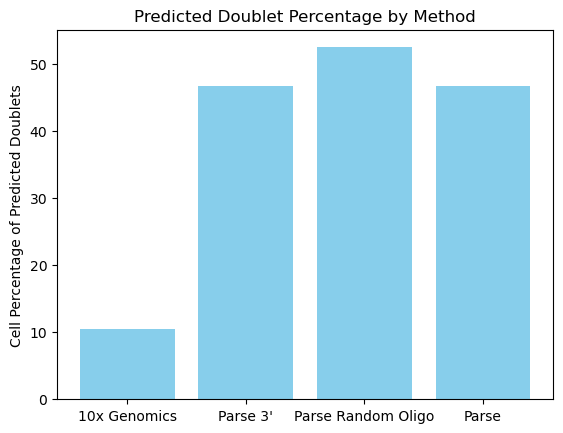

In [15]:
percent_doublets = []
doublet_thresh = 0.07

for data in datasets:
    percent_doublets.append((data.obs['doublet_score'] > doublet_thresh).sum() / data.shape[0] * 100)

plt.bar([data.uns['title'] for data in datasets], percent_doublets, color='skyblue')
plt.ylabel('Cell Percentage of Predicted Doublets')
plt.title('Predicted Doublet Percentage by Method')

plt.show()

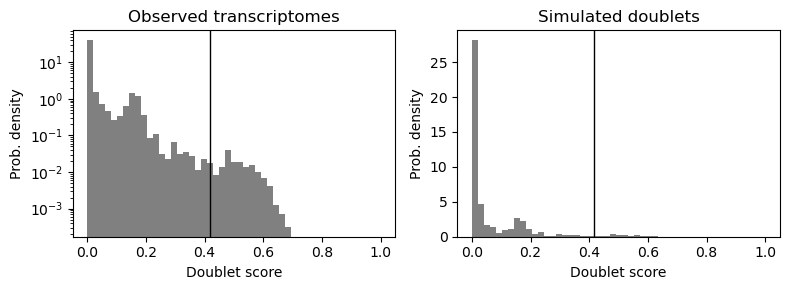

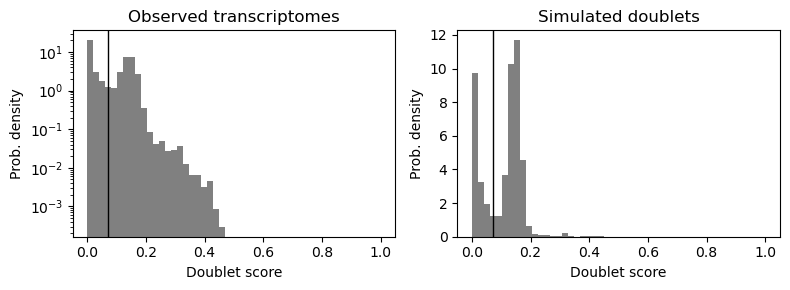

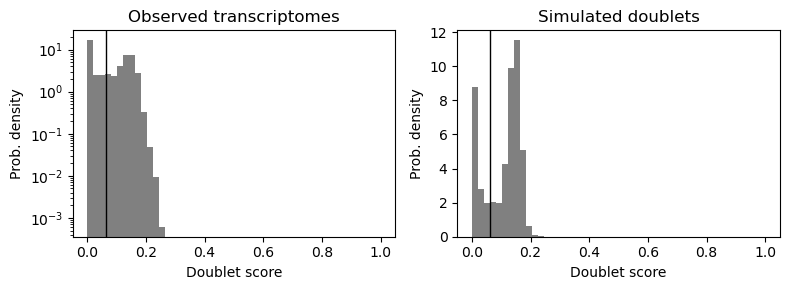

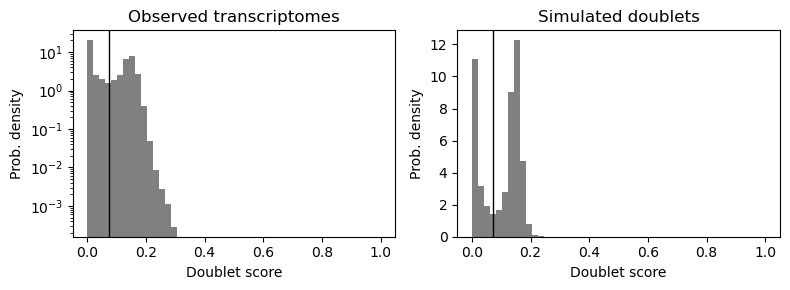

In [11]:
for scrub in scrubs:
    scrub.plot_histogram()

# Quality Control Comparison

In [68]:
# Scatter plot of genes detected vs. UMI counts
def scatter_reads(ax, data):
    x = np.asarray(data.X.sum(axis=1))[:,0]
    y = np.asarray(np.sum(data.X>0, axis=1))[:,0]

    ax.scatter(x, y, color="green", alpha=0.25)
    ax.set_xlabel("UMI Counts")
    ax.set_xscale('log')
    ax.set_yscale('log', nonpositive='clip')
    ax.set_title(data.uns['title'] + " Reads")

# Knee plot with threshold axes
def knee_plot(ax, data, cutoff = 20):
    knee = np.sort((np.array(data.X.sum(axis=1))).flatten())[::-1]
    cell_set = np.arange(len(knee))
    num_cells = cell_set[knee > cutoff][::-1][0]

    ax.loglog(knee, cell_set, linewidth=5, color="g")
    ax.axvline(x=cutoff, linewidth=3, color="k")
    ax.axhline(y=num_cells, linewidth=3, color="k")
    ax.set_xlabel("UMI Counts")
    ax.set_ylabel("")
    ax.set_title(data.uns['title'] + " Knee Plot")

    print(f"{num_cells:,.0f} cells passed the {cutoff} UMI threshold for {data.uns['title']}")
    sc.pp.filter_cells(data, min_counts=knee[num_cells])

# Scatter plot for mitochondrial percentage
def mito_scatter(ax, data):
    sc.pl.scatter(data, x='n_counts', y='percent_mito', ax=ax, show=False)
    ax.set_title(data.uns['title'])
    ax.set_xlabel("UMI Counts")
    ax.set_ylabel("")

# Generates violin plots of selected metadata
def violin_plots(ax_col, data, groups):
    for i, group in enumerate(groups):
        sc.pl.violin(data, group, ax=ax_col[i], stripplot=False, show=False)
        ax_col[i].set_xticks([])

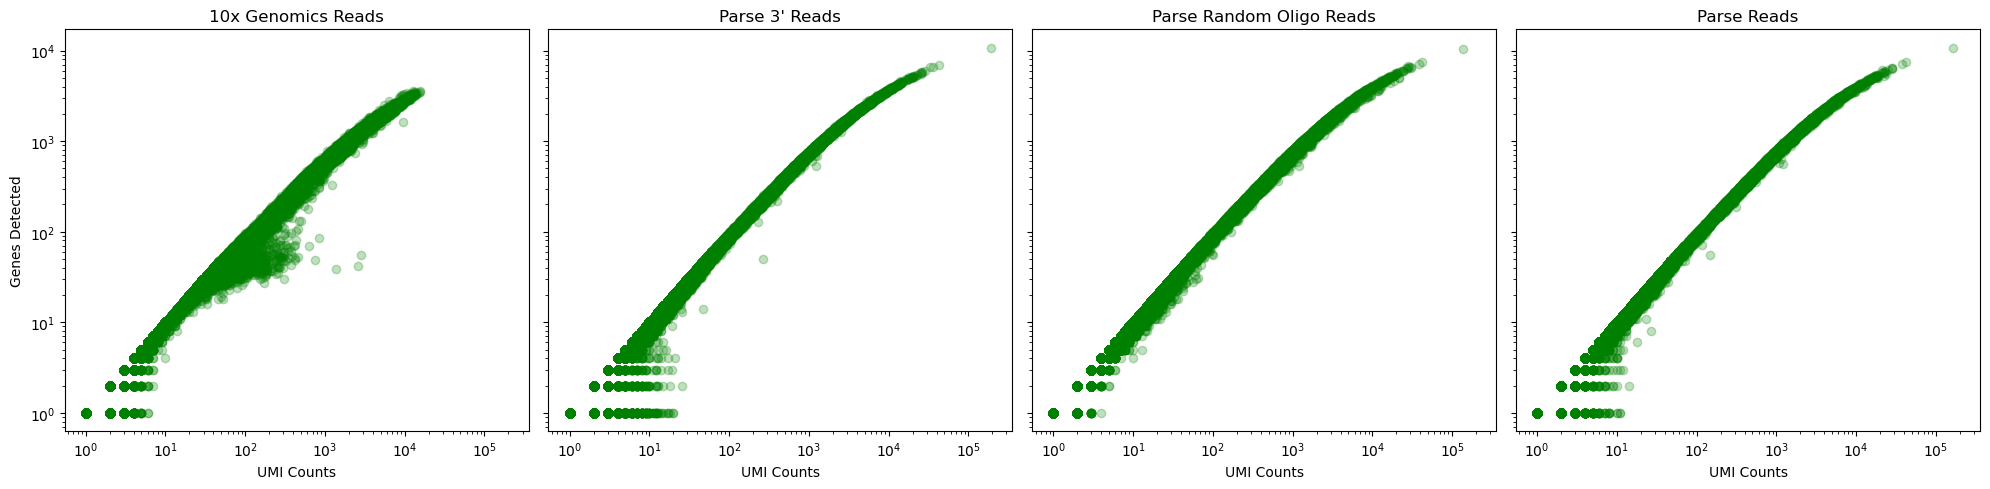

In [23]:
fig, ax = plt.subplots(1, 4, figsize=(20,5), sharey=True,sharex=True)
scatter_reads(ax[0], data_10x)
scatter_reads(ax[1], data_polyT)
scatter_reads(ax[2], data_randO)
scatter_reads(ax[3], data_parse)

ax[0].set_ylabel("Genes Detected")

plt.tight_layout()
plt.show()

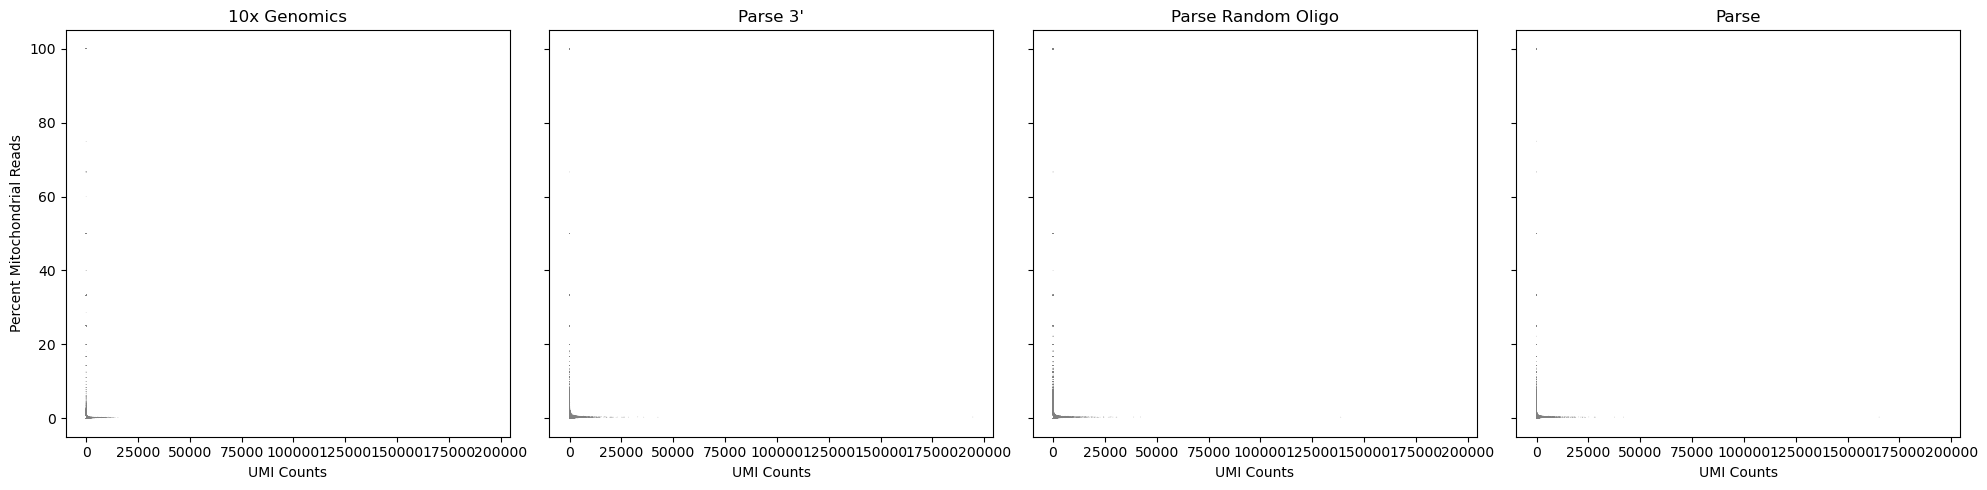

In [15]:
fig, ax = plt.subplots(1, 4, figsize=(20,5), sharey=True,sharex=True)
mito_scatter(ax[0], data_10x)
mito_scatter(ax[1], data_polyT)
mito_scatter(ax[2], data_randO)
mito_scatter(ax[3], data_parse)

ax[0].set_ylabel("Percent Mitochondrial Reads")

plt.tight_layout()
plt.show()

13,392 cells passed the 138 UMI threshold for 10x Genomics
13,386 cells passed the 298 UMI threshold for Parse 3'
13,384 cells passed the 252 UMI threshold for Parse Random Oligo
13,393 cells passed the 280 UMI threshold for Parse


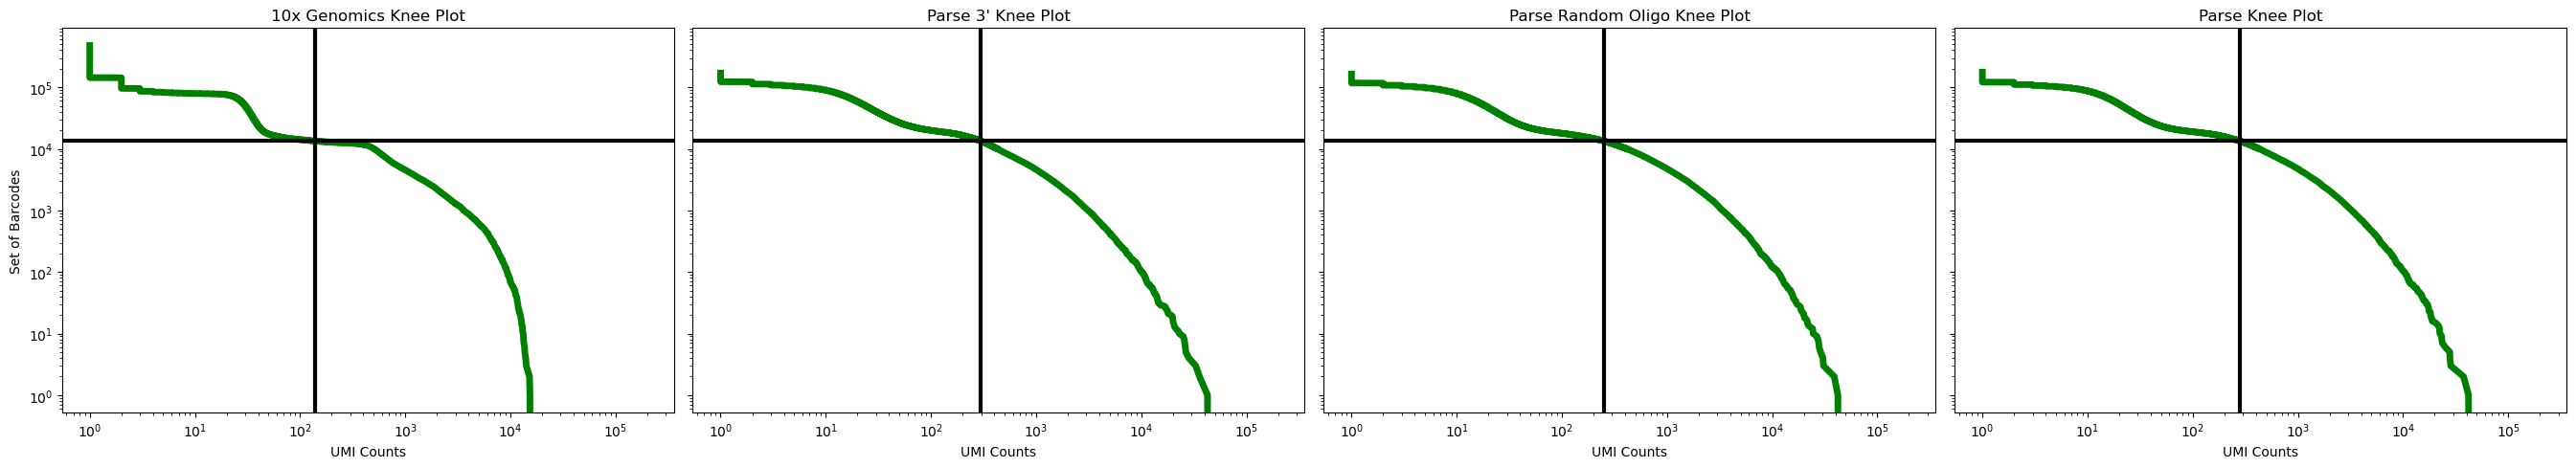

In [63]:
fig, ax = plt.subplots(1, 4, figsize=(27,5), sharey=True,sharex=True)
knee_plot(ax[0], data_10x, cutoff=138)
knee_plot(ax[1], data_polyT, cutoff = 298)
knee_plot(ax[2], data_randO, cutoff=252)
knee_plot(ax[3], data_parse, cutoff=280)

ax[0].set_ylabel("Set of Barcodes")

plt.tight_layout()
plt.show()

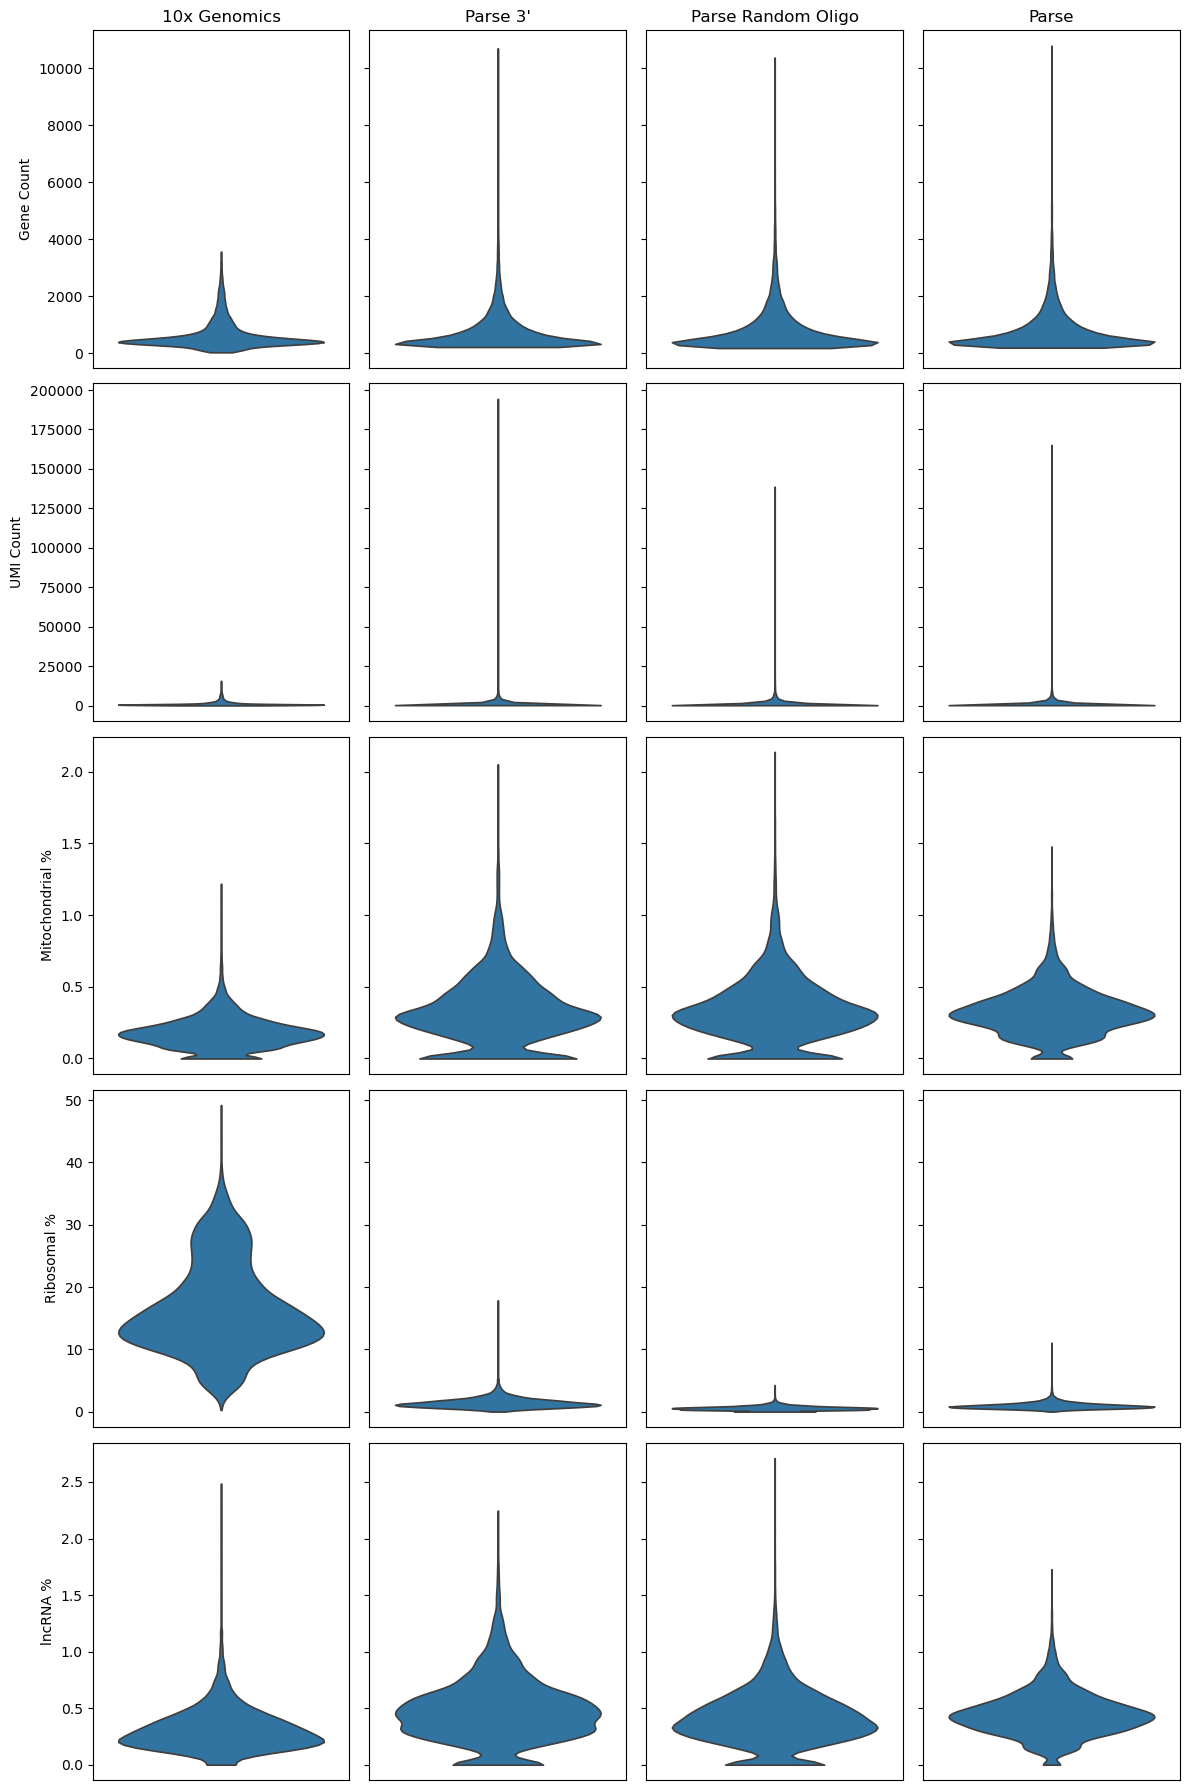

In [69]:
groups = ['n_genes', 'n_counts', 'percent_mito', 'percent_ribo', 'percent_lnc']
group_names = ['Gene Count', 'UMI Count', 'Mitochondrial %', 'Ribosomal %', 'lncRNA %']

fig, ax = plt.subplots(len(groups), 4, figsize=(12,18), sharey='row')
violin_plots(ax[:, 0], data_10x, groups)
violin_plots(ax[:, 1], data_polyT, groups)
violin_plots(ax[:, 2], data_randO, groups)
violin_plots(ax[:, 3], data_parse, groups)

for i, group in enumerate(group_names):
    ax[i,0].set_ylabel(group)

for i, data in enumerate(datasets):
    ax[0,i].set_title(data.uns['title'])

plt.tight_layout()
plt.show()

# Read/Transcript and Read/Gene Comparisons

In [28]:
# Displays violin plots of the distributions of the top 10 expressed gene/transcripts
# (by number of cells expressed in) by cell
def top_gene_cell_expression(ax, data):
    genes = data.var
    top_genes = genes.sort_values(by='n_cells',ascending=False).head(10).index

    gene_dist = []
    for gene in top_genes:
        gene_dist.append(np.nan_to_num(data[:,gene].X.toarray().transpose()[0] / np.array(data.obs['n_counts'].tolist()) * 100))

    ax.violinplot(gene_dist, showmeans=True)
    ax.set_xticks(np.arange(1, len(top_genes) + 1), top_genes)
    ax.set_ylabel("")
    ax.set_title(data.uns['title'] + " Top 10 Genes by Cell Expression")

def top_gene_counts(ax, data):
    genes = data.var
    top_genes = genes.sort_values(by='percent_counts',ascending=False).head(10).index

    gene_dist = []
    for gene in top_genes:
        gene_dist.append(np.nan_to_num(data[:,gene].X.toarray().transpose()[0] / np.array(data.obs['n_counts'].tolist()) * 100))

    ax.violinplot(gene_dist, showmeans=True)
    ax.set_xticks(np.arange(1, len(top_genes) + 1), top_genes)
    ax.set_ylabel("")
    ax.set_title(data.uns['title'] + " Top 10 Genes by Total Counts")

# compares the gene count percentatages between two methods
def compare_genes(data_x, data_y):
    x_name = data_x.uns['name']
    y_name = data_y.uns['name']

    shared_genes = list(set(data_y.var_names).intersection(set(data_x.var_names)))
    shared_data = data_x.var.loc[shared_genes, 'percent_counts'].copy().to_frame()
    shared_data.rename(columns={'percent_counts': x_name + '_percent_counts'}, inplace=True)
    shared_data[y_name + '_percent_counts'] = data_y.var.loc[shared_genes, 'percent_counts'].values
    shared_data.sort_values(by=x_name + '_percent_counts', inplace=True)

    #fit linear regression model
    model = sm.OLS(shared_data[y_name + '_percent_counts'], shared_data[x_name + '_percent_counts']).fit() 
    np.set_printoptions(suppress=True) # suppress scientific notation
    shared_data['cooks_distance'] = model.get_influence().cooks_distance[0] + 1e-10  # add small value to avoid log(0) issues

    return shared_data

# From the output of compare_genes, generates a scatter plot of the gene counts percentages 
# with each method on an axis
def scatter_genes(ax, shared_data, data_x, data_y,  xlim = None, ylim = None, norm = "log"):
    x_name = data_x.uns['name']
    y_name = data_y.uns['name']

    #Calculate correlation
    pearson_r = pearsonr(shared_data[x_name + '_percent_counts'], shared_data[y_name + '_percent_counts']).correlation
    spearman_r = spearmanr(shared_data[x_name + '_percent_counts'], shared_data[y_name + '_percent_counts']).correlation
    
    x_mean = shared_data[x_name + '_percent_counts'].mean()
    y_mean = shared_data[y_name + '_percent_counts'].mean()
    x_std = shared_data[x_name + '_percent_counts'].std()
    y_std = shared_data[y_name + '_percent_counts'].std()
    CCC_r = 2 * pearson_r * x_std * y_std / (x_std**2 + y_std**2 + (x_mean - y_mean)**2)

    ax.plot([0, 100], [0, 100], color='black', linestyle='--', linewidth=1.5)  # y=x line

    plot = ax.scatter(shared_data[x_name + '_percent_counts'], 
                shared_data[y_name + '_percent_counts'], 
                norm = norm, 
                alpha=0.5, 
                s=50, 
                c=shared_data['cooks_distance'], 
                cmap='viridis')
    
    ax.set_xlabel(data_x.uns['title'] + ' Gene Percent Count')
    ax.set_ylabel(data_y.uns['title'] + ' Gene Percent Count')
    if xlim:
        ax.set_xlim(0, xlim)
    if ylim:
        ax.set_ylim(0, ylim)

    textstr = '\n'.join((
    r'$\mathrm{r}=%.2f$' % (pearson_r, ),
    r'$\rho=%.2f$' % (spearman_r, ),
    r'$\rho_C=%.2f$' % (CCC_r, ),))
    ax.text(0.05, 0.85, textstr, transform = ax.transAxes, fontsize = 12)

    return plot

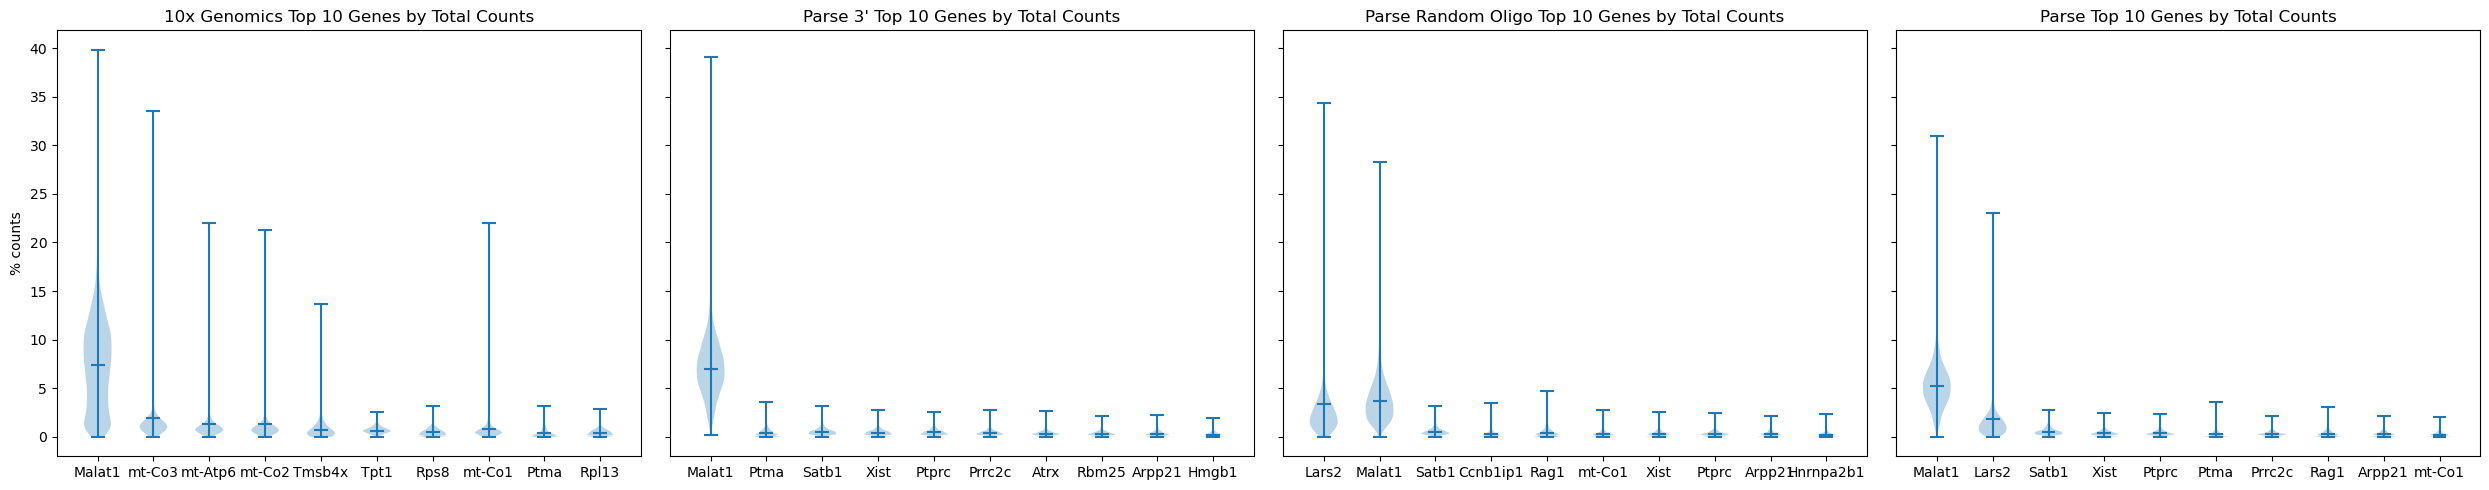

In [71]:
fig, ax = plt.subplots(1, 4, figsize=(25,5), sharey=True)
top_gene_counts(ax[0], data_10x)
top_gene_counts(ax[1], data_polyT)
top_gene_counts(ax[2], data_randO)
top_gene_counts(ax[3], data_parse)

ax[0].set_ylabel("% counts")

plt.tight_layout()
plt.show()

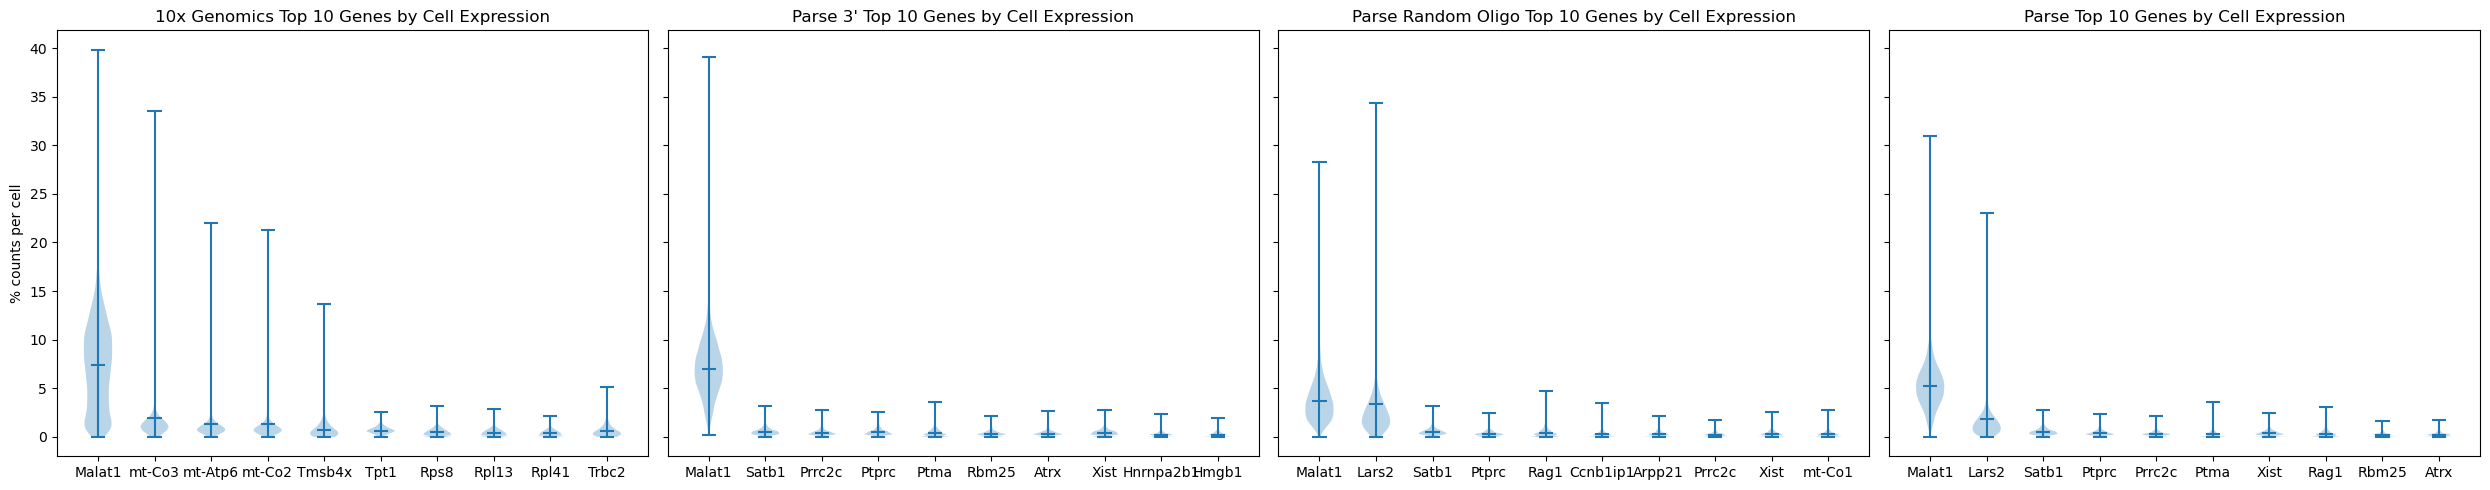

In [72]:
fig, ax = plt.subplots(1, 4, figsize=(25,5), sharey=True)
top_gene_cell_expression(ax[0], data_10x)
top_gene_cell_expression(ax[1], data_polyT)
top_gene_cell_expression(ax[2], data_randO)
top_gene_cell_expression(ax[3], data_parse)

ax[0].set_ylabel("% counts per cell")

plt.tight_layout()
plt.show()

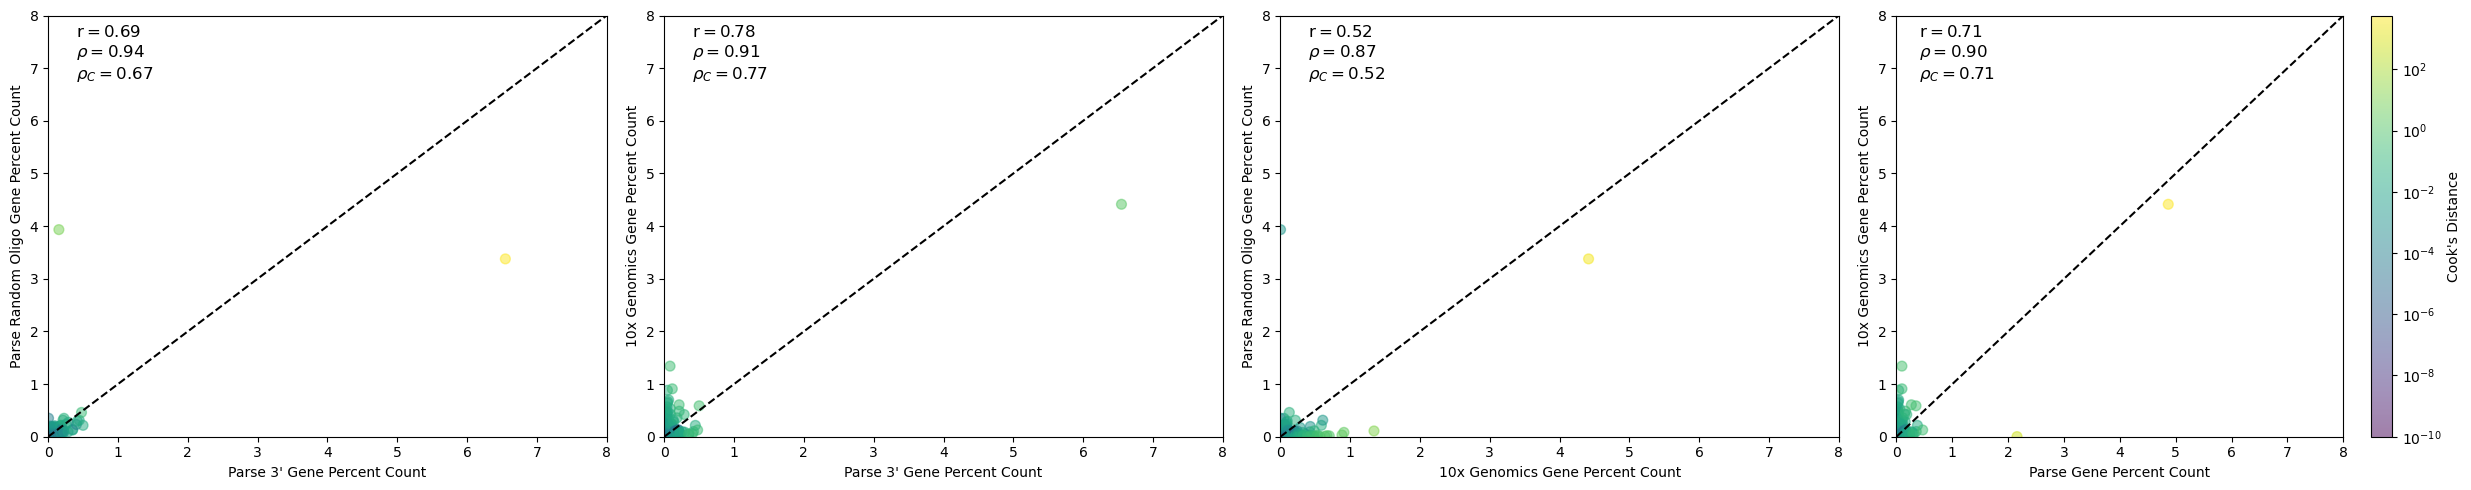

In [80]:
fig, axs = plt.subplots(1, 4, figsize = (25, 5))

xlim = 8
ylim = 8

TvO_genes = compare_genes(data_polyT, data_randO)
TvX_genes = compare_genes(data_polyT, data_10x)
XvO_genes = compare_genes(data_10x, data_randO)
PvX_genes = compare_genes(data_parse, data_10x)

c_values = TvO_genes['cooks_distance'].tolist() + TvX_genes['cooks_distance'].tolist() + XvO_genes['cooks_distance'].tolist()
norm = LogNorm(min(c_values), max(c_values))

scatter_genes(axs[0], TvO_genes, data_polyT, data_randO, xlim=xlim, ylim=ylim, norm=norm)
scatter_genes(axs[1], TvX_genes, data_polyT, data_10x, xlim=xlim, ylim=ylim,norm=norm)
scatter_genes(axs[2], XvO_genes, data_10x, data_randO, xlim=xlim, ylim=ylim,norm=norm)
plot = scatter_genes(axs[3], PvX_genes, data_parse, data_10x, xlim=xlim, ylim=ylim,norm=norm)

fig.colorbar(plot, label = "Cook's Distance")

plt.tight_layout()
plt.show()

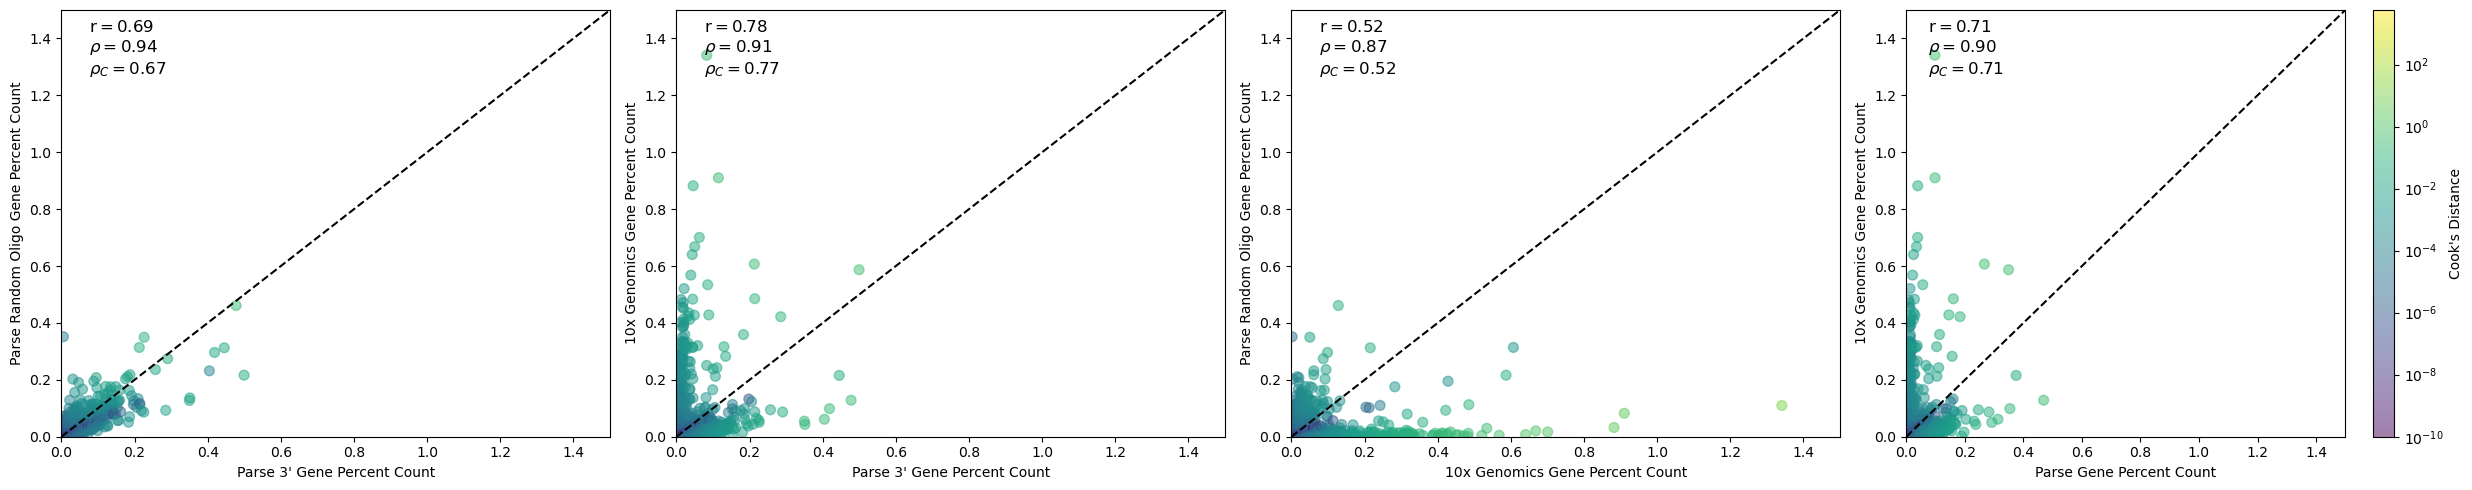

In [81]:
fig, axs = plt.subplots(1, 4, figsize = (25, 5))

xlim = 1.5
ylim = 1.5

TvO_genes = compare_genes(data_polyT, data_randO)
TvX_genes = compare_genes(data_polyT, data_10x)
XvO_genes = compare_genes(data_10x, data_randO)
PvX_genes = compare_genes(data_parse, data_10x)

c_values = TvO_genes['cooks_distance'].tolist() + TvX_genes['cooks_distance'].tolist() + XvO_genes['cooks_distance'].tolist()
norm = LogNorm(min(c_values), max(c_values))

scatter_genes(axs[0], TvO_genes, data_polyT, data_randO, xlim=xlim, ylim=ylim, norm=norm)
scatter_genes(axs[1], TvX_genes, data_polyT, data_10x, xlim=xlim, ylim=ylim,norm=norm)
scatter_genes(axs[2], XvO_genes, data_10x, data_randO, xlim=xlim, ylim=ylim,norm=norm)
plot = scatter_genes(axs[3], PvX_genes, data_parse, data_10x, xlim=xlim, ylim=ylim,norm=norm)

fig.colorbar(plot, label = "Cook's Distance")

plt.tight_layout()
plt.show()

In [74]:
for shared_data, string in zip([TvO_genes, TvX_genes, XvO_genes, PvX_genes], ("polyT vs randO", "polyT vs 10X", "10X vs randO", "Parse vs 10X")):
    shared_data.sort_values(by='cooks_distance', ascending=False, inplace=True)
    print("Top 10 outliers based on Cook's distance for", string, ":",  shared_data.index[:10].tolist())

Top 10 outliers based on Cook's distance for polyT vs randO : ['Malat1', 'Lars2', 'Satb1', 'Rag1', 'mt-Co1', 'Arpp21', 'Ptma', 'Xist', 'Ptprc', 'Hnrnpa2b1']
Top 10 outliers based on Cook's distance for polyT vs 10X : ['Malat1', 'Ptma', 'mt-Co3', 'mt-Co1', 'mt-Atp6', 'Satb1', 'Prrc2c', 'Ptprc', 'Actb', 'Atrx']
Top 10 outliers based on Cook's distance for 10X vs randO : ['Malat1', 'mt-Co3', 'mt-Co2', 'mt-Atp6', 'Tmsb4x', 'Tpt1', 'Rps8', 'Rpl13', 'Rpl41', 'Trbc2']
Top 10 outliers based on Cook's distance for Parse vs 10X : ['Malat1', 'Lars2', 'mt-Co3', 'Ptma', 'mt-Co1', 'Satb1', 'mt-Atp6', 'Ptprc', 'Actb', 'Prrc2c']


In [75]:
for data in datasets:
    name = data.uns['title']
    genes = data.var
    top_genes = genes.sort_values(by='n_cells',ascending=False).head(10).index.tolist()
    print("Top 10 genes in", name, "data:")
    print(top_genes)
    print()

Top 10 genes in 10x Genomics data:
['Malat1', 'mt-Co3', 'mt-Atp6', 'mt-Co2', 'Tmsb4x', 'Tpt1', 'Rps8', 'Rpl13', 'Rpl41', 'Trbc2']

Top 10 genes in Parse 3' data:
['Malat1', 'Satb1', 'Prrc2c', 'Ptprc', 'Ptma', 'Rbm25', 'Atrx', 'Xist', 'Hnrnpa2b1', 'Hmgb1']

Top 10 genes in Parse Random Oligo data:
['Malat1', 'Lars2', 'Satb1', 'Ptprc', 'Rag1', 'Ccnb1ip1', 'Arpp21', 'Prrc2c', 'Xist', 'mt-Co1']

Top 10 genes in Parse data:
['Malat1', 'Lars2', 'Satb1', 'Ptprc', 'Prrc2c', 'Ptma', 'Xist', 'Rag1', 'Rbm25', 'Atrx']



In [70]:
with open("t2g.txt") as t2g:
    gene_ids = []
    for line in t2g:
        gene_ids.append(line.strip().split()[1])
gene_ids = list(set(gene_ids))
df_genes = pd.DataFrame({'gene_ids': gene_ids})

In [71]:
dict = {}

for data in datasets:
    dict[str(data.uns['name'])] = (df_genes['gene_ids'].isin(data.var['gene_codes'])).tolist()
contents = pd.DataFrame(dict) 

upset = Upset.generate_plot(contents)
upset.show()
            

In [73]:
dict = {}

for data in datasets:
    top_data = data.var.sort_values(by='percent_counts',ascending=False).head(1000)
    dict[str(data.uns['name'])] = (df_genes['gene_ids'].isin(top_data['gene_codes'])).tolist()
contents = pd.DataFrame(dict) 

upset = Upset.generate_plot(contents)
upset.show()

In [56]:
for data in datasets:
    gene_data = data.var['gene_codes'].str.split('.').str[0].tolist()
    

print(gene_data)

['ENSMUSG00000100764', 'ENSMUSG00000100480', 'ENSMUSG00000051285', 'ENSMUSG00000097797', 'ENSMUSG00000103067', 'ENSMUSG00000026312', 'ENSMUSG00000039748', 'ENSMUSG00000104158', 'ENSMUSG00000057363', 'ENSMUSG00000038702', 'ENSMUSG00000033021', 'ENSMUSG00000055214', 'ENSMUSG00000070695', 'ENSMUSG00000025909', 'ENSMUSG00000094429', 'ENSMUSG00000061024', 'ENSMUSG00000100617', 'ENSMUSG00000026374', 'ENSMUSG00000026377', 'ENSMUSG00000025911', 'ENSMUSG00000067879', 'ENSMUSG00000057335', 'ENSMUSG00000103435', 'ENSMUSG00000025912', 'ENSMUSG00000045210', 'ENSMUSG00000041763', 'ENSMUSG00000026504', 'ENSMUSG00000047343', 'ENSMUSG00000087082', 'ENSMUSG00000091844', 'ENSMUSG00000026483', 'ENSMUSG00000019699', 'ENSMUSG00000097892', 'ENSMUSG00000063659', 'ENSMUSG00000102432', 'ENSMUSG00000026049', 'ENSMUSG00000043019', 'ENSMUSG00000032666', 'ENSMUSG00000100685', 'ENSMUSG00000015961', 'ENSMUSG00000014980', 'ENSMUSG00000026235', 'ENSMUSG00000032649', 'ENSMUSG00000026047', 'ENSMUSG00000091476', 'ENSMUSG0